Taille univers: 300
New best: 17/300
New best: 32/300
New best: 46/300
New best: 59/300
New best: 71/300
New best: 82/300
New best: 93/300
New best: 104/300
New best: 115/300
New best: 126/300
New best: 136/300
New best: 146/300
New best: 155/300
New best: 164/300
New best: 173/300
New best: 181/300
New best: 189/300
New best: 196/300
New best: 203/300
New best: 210/300
New best: 217/300
New best: 223/300
New best: 229/300
New best: 235/300
New best: 240/300
New best: 245/300
New best: 250/300
New best: 255/300
New best: 260/300
New best: 264/300
New best: 268/300
New best: 272/300
New best: 276/300
New best: 280/300
New best: 283/300
New best: 286/300
New best: 289/300
New best: 292/300
New best: 294/300

Résultats finaux:
Subsets sélectionnés: 39/39
Couverture: 294/300
Ratio: 98.0%
Noeuds explorés: 2286823
Temps: 60.34s


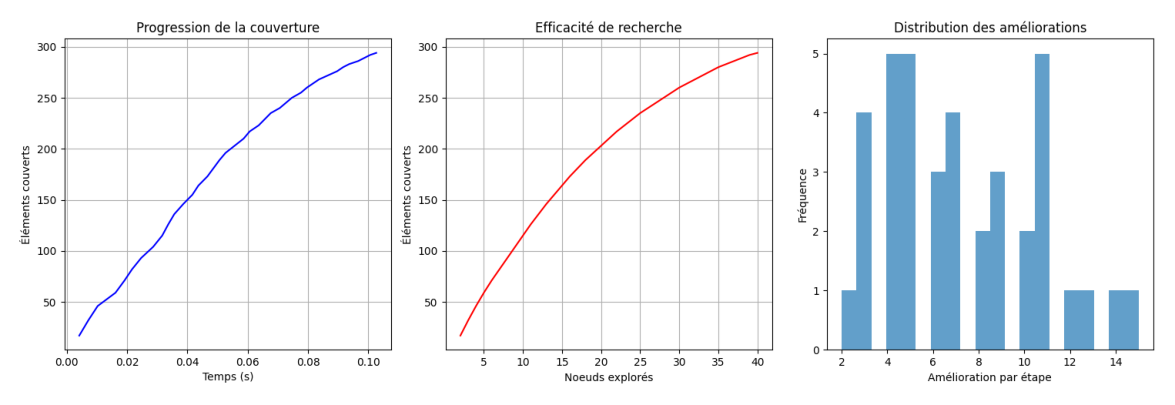

In [4]:
from math import ceil
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.image as mpimg
import numpy as np

class Benchmark:
    def __init__(self, file_path, benchmark_type):
        self.file_path = file_path
        self.benchmark_type = benchmark_type
        self.subsets, self.universe_size, self.num_subsets = self.read_benchmark()
    
    def read_benchmark(self):
        """Lecture d'un benchmark MCP à partir d'un fichier texte"""
        with open(self.file_path, "r") as file:
            lines = file.readlines()
        
        m, n = map(int, lines[0].split())
        cost_lines_to_skip = ceil(n / 12) if self.benchmark_type == "4" else ceil(n / 15)
        subset_start_index = 1 + cost_lines_to_skip
        
        data_lines = lines[subset_start_index:]
        row_to_subsets = {}
        index = 0
        
        for row in range(1, m + 1):
            num_subsets = int(data_lines[index].strip())
            index += 1
            subsets = []
            while len(subsets) < num_subsets:
                subsets.extend(map(int, data_lines[index].split()))
                index += 1
            row_to_subsets[row] = subsets
        
        subset_to_rows = {}
        for row, subsets in row_to_subsets.items():
            for subset in subsets:
                if subset not in subset_to_rows:
                    subset_to_rows[subset] = []
                subset_to_rows[subset].append(row)
        return subset_to_rows, m, n

class DFSSolver:
    def __init__(self, benchmark, timeout=300):
        self.benchmark = benchmark
        # self.k = ceil(benchmark.universe_size * 2 / 3)
        self.k = ceil(benchmark.universe_size * 0.2) if benchmark.benchmark_type == "4" else ceil(benchmark.universe_size * 0.13)
        self.timeout = timeout
        self.start_time = None
        self.best_solution = []
        self.best_coverage = 0
        self.nodes_explored = 0
        self.timeout_occurred = False
        self.progress_data = {
            'time': [],
            'coverage': [],
            'nodes': []
        }
    
    def solve(self):
        """Exécution principale avec tracking des données"""
        self.start_time = time.time()
        remaining = set(self.benchmark.subsets.keys())
        self.dfs(remaining, [], set())
        
        self.visualize_progress()
        return {
            "k": self.k,
            "selected_subsets": self.best_solution,
            "coverage": self.best_coverage,
            "coverage_ratio": self.best_coverage / self.benchmark.universe_size,
            "nodes_explored": self.nodes_explored,
            "timeout_occurred": self.timeout_occurred,
            "time_taken": time.time() - self.start_time
        }
    
    def dfs(self, remaining, selected, covered):
        """DFS avec tracking des données"""
        if self.check_timeout():
            return
        
        self.nodes_explored += 1
        current_time = time.time() - self.start_time
        current_cov = len(covered)
        
        # Mise à jour des données de progression
        if current_cov > self.best_coverage:
            self.best_coverage = current_cov
            self.best_solution = selected.copy()
            self.progress_data['time'].append(current_time)
            self.progress_data['coverage'].append(current_cov)
            self.progress_data['nodes'].append(self.nodes_explored)
            print(f"New best: {self.best_coverage}/{self.benchmark.universe_size}")
        
        if len(selected) == self.k or self.best_coverage == self.benchmark.universe_size:
            return
        
        if len(selected) + len(remaining) < self.k:
            return
        
        upper_bound = current_cov + self.calculate_remaining_coverage(remaining, covered)
        if upper_bound <= self.best_coverage:
            return
        
        for subset in sorted(remaining, 
                           key=lambda s: len(set(self.benchmark.subsets[s]) - covered),
                           reverse=True):
            if self.check_timeout():
                return
            new_covered = covered | set(self.benchmark.subsets[subset])
            self.dfs(remaining - {subset}, selected + [subset], new_covered)
    
    def calculate_remaining_coverage(self, remaining, covered):
        return len(set().union(*[self.benchmark.subsets[s] for s in remaining]) - covered)
    
    def check_timeout(self):
        if time.time() - self.start_time > self.timeout:
            self.timeout_occurred = True
            return True
        return False
    
    def visualize_progress(self):
        """Visualisation des données de progression"""
        plt.figure(figsize=(15, 5))
        
        # Graphique de couverture vs temps
        plt.subplot(1, 3, 1)
        plt.plot(self.progress_data['time'], self.progress_data['coverage'], 'b-')
        plt.xlabel('Temps (s)')
        plt.ylabel('Éléments couverts')
        plt.title('Progression de la couverture')
        plt.grid(True)
        
        # Graphique de couverture vs noeuds explorés
        plt.subplot(1, 3, 2)
        plt.plot(self.progress_data['nodes'], self.progress_data['coverage'], 'r-')
        plt.xlabel('Noeuds explorés')
        plt.ylabel('Éléments couverts')
        plt.title('Efficacité de recherche')
        plt.grid(True)
        
        # Graphique de distribution des améliorations
        plt.subplot(1, 3, 3)
        if len(self.progress_data['coverage']) > 1:
            improvements = np.diff(self.progress_data['coverage'])
            plt.hist(improvements, bins=20, alpha=0.7)
            plt.xlabel('Amélioration par étape')
            plt.ylabel('Fréquence')
            plt.title('Distribution des améliorations')
        
        plt.tight_layout()
        plt.savefig('dfs_progress.png')
        plt.close()

if __name__ == "__main__":
    benchmark = Benchmark("./Benchmark/A/scpa1.txt", "A")
    print(f"Taille univers: {benchmark.universe_size}")
    # print(f"k calculé: {ceil(benchmark.universe_size * 2 / 3)}")
    
    solver = DFSSolver(benchmark, timeout=60)
    result = solver.solve()
    
    print("\nRésultats finaux:")
    print(f"Subsets sélectionnés: {len(result['selected_subsets'])}/{result['k']}")
    print(f"Couverture: {result['coverage']}/{benchmark.universe_size}")
    print(f"Ratio: {result['coverage_ratio']:.1%}")
    print(f"Noeuds explorés: {result['nodes_explored']}")
    print(f"Temps: {result['time_taken']:.2f}s")
    
    # Affichage de la visualisation

    img = mpimg.imread('dfs_progress.png')
    plt.figure(figsize=(15, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()